In [1]:
from pathlib import Path
import pandas as pd 
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path('datasets/housing.tgz')
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/housing.tgz'
        urllib.request.urlretrieve(url=url, filename=tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path('datasets/housing/housing.csv'))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

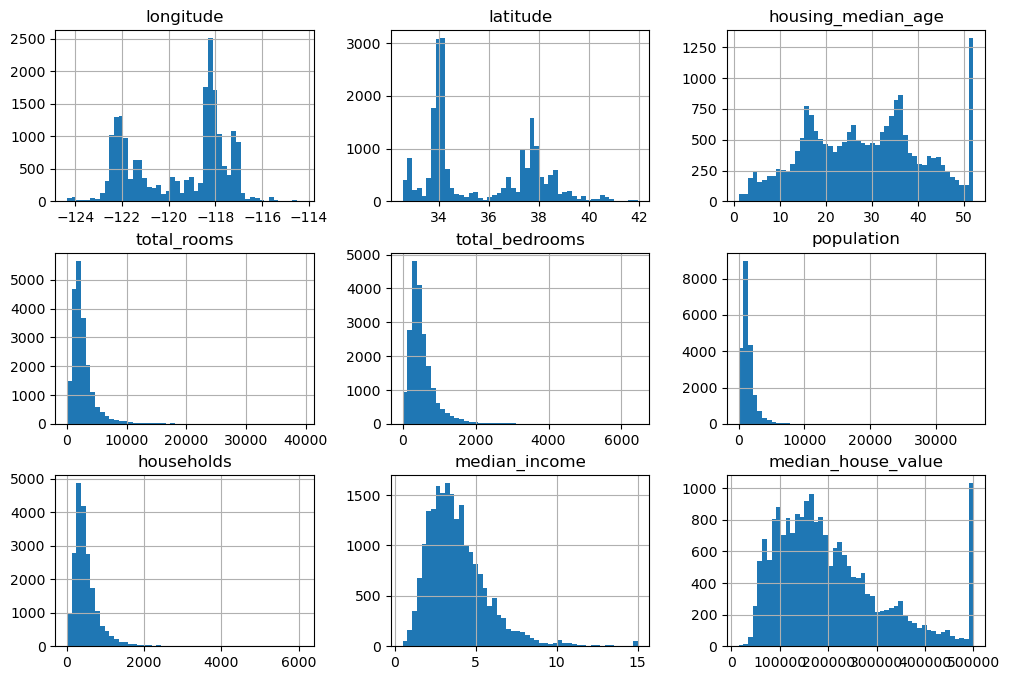

In [5]:
housing.hist(bins=50, figsize=(12, 8));

In [6]:
import numpy as np

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

Text(0, 0.5, 'Number of categories')

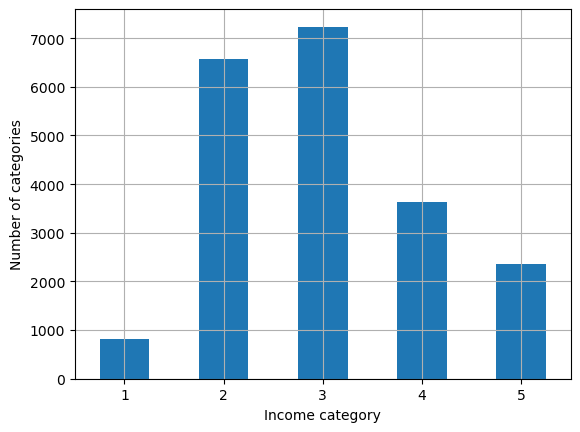

In [7]:
import matplotlib.pyplot as plt

housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income category')
plt.ylabel('Number of categories')

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'])

In [9]:
train_set['income_cat'].value_counts() / len(train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [10]:
for set_ in (train_set, test_set):
    set_.drop('income_cat', axis=1, inplace=True)


In [11]:
housing = train_set.copy()

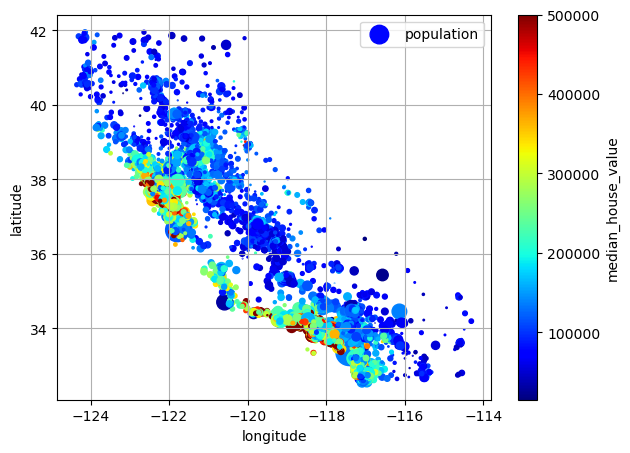

In [12]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, s=housing['population'] / 100, label='population',
             c='median_house_value', cmap='jet', colorbar=True, legend=True, sharex=False, figsize=(7, 5));

In [13]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689184
total_rooms           0.129817
housing_median_age    0.103227
households            0.062589
total_bedrooms        0.046493
population           -0.025295
longitude            -0.045473
latitude             -0.145122
Name: median_house_value, dtype: float64

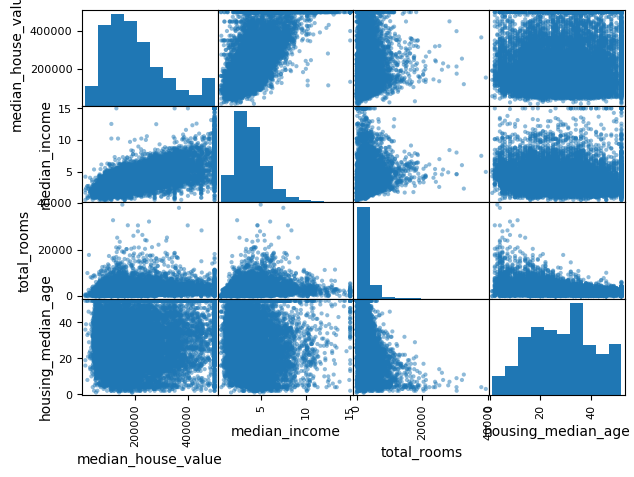

In [14]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(7, 5));

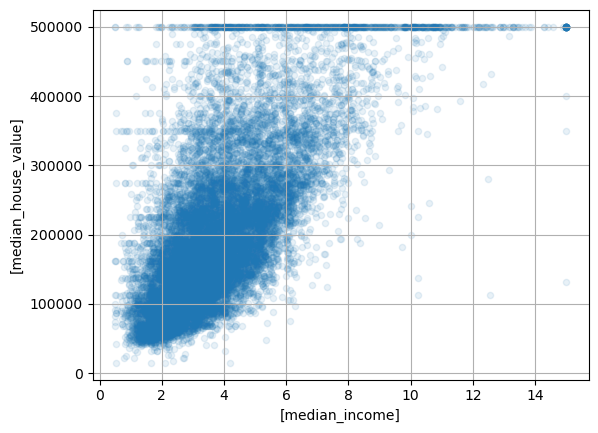

In [15]:
housing.plot(kind='scatter', x=['median_income'], y=['median_house_value'], alpha=0.1, grid=True);

In [16]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
65,-122.30,37.81,52.0,1010.0,209.0,604.0,187.0,1.1667,78400.0,NEAR BAY
14707,-118.53,34.27,33.0,1927.0,305.0,896.0,293.0,5.6340,320500.0,<1H OCEAN
5918,-121.80,37.69,17.0,3956.0,639.0,2222.0,662.0,5.4324,215500.0,INLAND
9183,-121.84,36.61,26.0,2902.0,761.0,2258.0,719.0,2.5663,128900.0,<1H OCEAN
11466,-122.21,37.44,35.0,1140.0,193.0,486.0,199.0,4.6908,500001.0,NEAR OCEAN


In [17]:
housing['rooms_per_house'] = housing.total_rooms / housing.households
housing['bedrooms_ratio'] = housing.total_bedrooms / housing.total_rooms
housing['people_per_house'] = housing.population / housing.households

In [18]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689184
rooms_per_house       0.152227
total_rooms           0.129817
housing_median_age    0.103227
households            0.062589
total_bedrooms        0.046493
people_per_house     -0.019454
population           -0.025295
longitude            -0.045473
latitude             -0.145122
bedrooms_ratio       -0.255492
Name: median_house_value, dtype: float64

In [19]:
housing = train_set.drop('median_house_value', axis=1)
housing_labels = train_set['median_house_value'].copy()

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [21]:
housing_num = housing.select_dtypes(include=[np.number])

In [22]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [23]:
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2119.    ,  433.    , 1164.    ,
        408.    ,    3.5313])

In [24]:
housing_num.median().values

array([-118.5   ,   34.26  ,   29.    , 2119.    ,  433.    , 1164.    ,
        408.    ,    3.5313])

In [25]:
X = imputer.transform(housing_num)

In [26]:
housing_trn = pd.DataFrame(X, index=housing_num.index, columns=housing_num.columns)

In [27]:
housing_cat = housing.select_dtypes(exclude=np.number)

In [28]:
housing_cat.head()

,ocean_proximity
65,NEAR BAY
14707,<1H OCEAN
5918,INLAND
9183,<1H OCEAN
11466,NEAR OCEAN


In [29]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [30]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [31]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [32]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

In [33]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
housing_num_standard_scaled = standard_scaler.fit_transform(housing_num)

In [34]:
from sklearn.linear_model import LinearRegression

target_scalar = StandardScaler()
scaled_labels = target_scalar.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5] # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scalar.inverse_transform(scaled_predictions)

In [35]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

### Custom Transformer

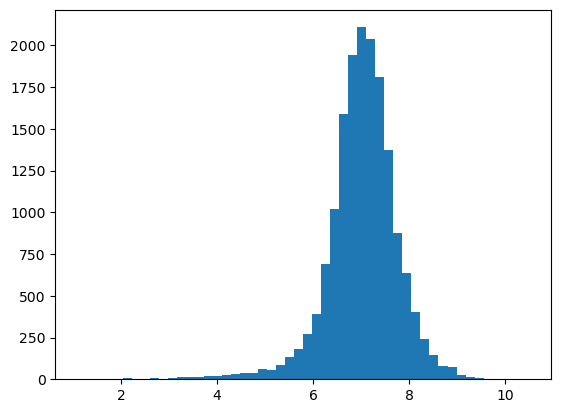

In [36]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing['population'])
plt.hist(x=log_pop, bins=50);

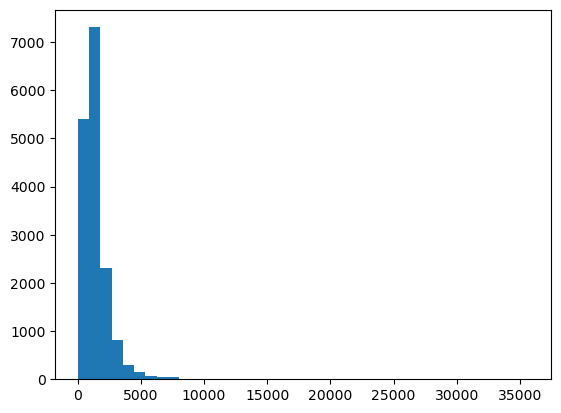

In [37]:
plt.hist(housing['population'], bins=40);

In [38]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

In [39]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])

In [40]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalarClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no *args and **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):   # y is required even though we don't use it
        X = check_array(X)      # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]    # every estimator stores this in fit()
        return self # always return self!
    
    def transform(self, X):
        check_is_fitted(self)   # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X -= self.mean_
        return X / self.scale_

In [42]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0):
        self.n_clusters = n_clusters
        self.gamma = gamma
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return (f'Cluster {i} similarity' for i in range(self.n_clusters))

In [43]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_labels)

In [44]:
similarities[:3].round(2)

array([[0.  , 0.19, 0.  , 0.99, 0.  , 0.12, 0.  , 0.  , 0.66, 0.  ],
       [0.02, 0.  , 0.8 , 0.  , 0.22, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.54, 0.  , 0.72, 0.  , 0.23, 0.  , 0.  , 0.81, 0.  ]])

### Transformation Pipeline

In [45]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

In [46]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

In [47]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.36,  1.02,  1.85, -0.74, -0.77, -0.71, -0.81, -1.42],
       [ 0.52, -0.64,  0.34, -0.32, -0.55, -0.46, -0.53,  0.92]])

In [48]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

In [49]:
from sklearn.compose import ColumnTransformer

num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs = ['ocean_proximity']

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [50]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=np.object_))
)

In [51]:
housing_prepared = preprocessing.fit_transform(housing)

In [52]:
class RatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return (X[:, [0]] / X[:, [1]])
    
    def get_feature_names_out(self, input_features=None):
        return ['ratio']
    
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log(X)

    def inverse_transform(self, X):
        return np.exp(X)

    def get_feature_names_out(self, input_features=None):
        return [f"log_{f}" for f in input_features]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        RatioTransformer(),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    LogTransformer(),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline)

In [53]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [54]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__log_total_bedrooms',
       'log__log_total_rooms', 'log__log_population',
       'log__log_households', 'log__log_median_income',
       'geo__Cluster 0 similarity', 'geo__Cluster 1 similarity',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity', 'geo__Cluster 5 similarity',
       'geo__Cluster 6 similarity', 'geo__Cluster 7 similarity',
       'geo__Cluster 8 similarity', 'geo__Cluster 9 similarity',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

### Select and Train a Model

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratiotransformer',
                                                                   RatioTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_b...
                                                   'households',
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6d3e29f4a0>)])),
                ('linearregression', LinearRegression())])

In [56]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)   # -2 = rounded to the nearest hundred

array([102300., 312900., 247300., 151400., 343900.])

In [57]:
housing_labels.iloc[:5].values

array([ 78400., 320500., 215500., 128900., 500001.])

In [58]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

69251.93229507194

In [59]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratiotransformer',
                                                                   RatioTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_b...
                                                   'households',
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6d3e29f4a0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [60]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

### Better Evaluation Using Cross-Validation

In [61]:
from sklearn.model_selection import cross_val_score

tree_rmse = -cross_val_score(tree_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=10)

In [62]:
pd.Series(tree_rmse).describe()

count       10.000000
mean     65621.762246
std       2104.399904
min      60863.295733
25%      64876.404181
50%      65710.701667
75%      67320.559359
max      67830.173194
dtype: float64

In [67]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor())
forest_rmse = -cross_val_score(forest_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=5)

In [68]:
pd.Series(forest_rmse).describe()

count        5.000000
mean     46958.972900
std       1642.119096
min      45316.190304
25%      45958.762582
50%      46271.632136
75%      47893.021890
max      49355.257590
dtype: float64

### Fine-Tune your Model

In [69]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor())
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=2, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)


/home/nemo/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ratiotransformer',
                                                                                          RatioTransformer()),
                                                                                         ('standardscaler',
                                                                                          Stand...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6d3e29f4a0>)])),
                                       ('random_forest',
                                        RandomForestRegressor())]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [70]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [86]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res.drop(labels=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params',
                     'std_test_score', 'rank_test_score'], axis=1, inplace=True)
cv_res.rename({'param_preprocessing__geo__n_clusters': 'n_clusters', 'param_random_forest__max_features': 'max_features',
               'split0_test_score': 'split0', 'split1_test_score': 'split1'}, axis=1, inplace=True)
cv_res['mean_test_rmse'] = -cv_res['mean_test_score']
cv_res.head()

,n_clusters,max_features,split0,split1,mean_test_score,mean_test_rmse
12,15,6,-45323.210351,-44157.326800,-44740.268575,44740.268575
13,15,8,-46123.091328,-44229.592156,-45176.341742,45176.341742
14,15,10,-46489.450416,-44631.805500,-45560.627958,45560.627958
9,10,6,-46530.950540,-45180.764965,-45855.857752,45855.857752
7,10,6,-46514.968534,-45464.995943,-45989.982238,45989.982238


### Randomized Search

In [91]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, scoring='neg_root_mean_squared_error', n_iter=10, cv=2, verbose=4
)

rnd_search.fit(housing, housing_labels)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END preprocessing__geo__n_clusters=13, random_forest__max_features=13;, score=-47298.613 total time=   6.5s
[CV 2/2] END preprocessing__geo__n_clusters=13, random_forest__max_features=13;, score=-45397.748 total time=   6.3s
[CV 1/2] END preprocessing__geo__n_clusters=48, random_forest__max_features=14;, score=-44427.596 total time=   7.0s
[CV 2/2] END preprocessing__geo__n_clusters=48, random_forest__max_features=14;, score=-42186.892 total time=   7.1s
[CV 1/2] END preprocessing__geo__n_clusters=49, random_forest__max_features=8;, score=-43810.951 total time=   4.3s
[CV 2/2] END preprocessing__geo__n_clusters=49, random_forest__max_features=8;, score=-42098.720 total time=   4.2s
[CV 1/2] END preprocessing__geo__n_clusters=17, random_forest__max_features=9;, score=-45985.995 total time=   4.7s
[CV 2/2] END preprocessing__geo__n_clusters=17, random_forest__max_features=9;, score=-44088.374 total time=   4.6s
[CV 1/2

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('ratiotransformer',
                                                                                                RatioTransformer()),
                                                                                               ('standardscaler'...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7f6d3e29f4a0>)])),
                                             ('random_forest',
                                              RandomForestRegressor())]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f6d02862210>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f6d02861970>},
                   scoring='neg_root_mean_squared_error', verbose=4)

In [94]:
final_model = rnd_search.best_estimator_    # includes preprocessing
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.04, 0.01, 0.01, 0.01, 0.01, 0.16, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.02, 0.  , 0.02, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.02, 0.01,
       0.01, 0.01, 0.  , 0.08, 0.  , 0.  , 0.  , 0.01])

In [95]:
sorted(zip(feature_importances,
           final_model['preprocessing'].get_feature_names_out()),
           reverse=True)

[(0.16230056276074156, 'log__log_median_income'),
 (0.0756605681817057, 'cat__ocean_proximity_INLAND'),
 (0.07148030378468896, 'bedrooms__ratio'),
 (0.057077447758839404, 'rooms_per_house__ratio'),
 (0.043668132352965135, 'people_per_house__ratio'),
 (0.027986268808223417, 'geo__Cluster 22 similarity'),
 (0.024038655902452508, 'geo__Cluster 3 similarity'),
 (0.02077475415954904, 'geo__Cluster 36 similarity'),
 (0.019839187337083432, 'geo__Cluster 45 similarity'),
 (0.01969925286114685, 'geo__Cluster 19 similarity'),
 (0.019141165119357702, 'geo__Cluster 26 similarity'),
 (0.016585449064988808, 'geo__Cluster 8 similarity'),
 (0.01654787712110614, 'geo__Cluster 42 similarity'),
 (0.015680118748554683, 'geo__Cluster 10 similarity'),
 (0.015332661153070257, 'geo__Cluster 14 similarity'),
 (0.014543143436688355, 'geo__Cluster 25 similarity'),
 (0.01439044776308699, 'geo__Cluster 38 similarity'),
 (0.0139027516910608, 'geo__Cluster 20 similarity'),
 (0.01316518089556653, 'geo__Cluster 16 sim

### Evaluate Your System on the Test Set

In [97]:
X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value']

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

42441.843441607285


In [98]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([40195.8258315 , 44574.83297969])